In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

from rdkit import Chem
# suppress rdkit warning
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
from scipy.special import softmax

def binary_cls(cls):
    if cls == 0 or cls == 1:
        return 0
    elif cls == 2 or cls == 3:
        return 1
    else:
        return None
    
def binary_pred(pred):
    pred = np.array(pred.split(','), dtype=float)
    pred_b = np.array([pred[0]+pred[1], pred[2]+pred[3]])
    pred_b = softmax(pred_b)
    return pred_b[1] # the probability to unsolved

## 1. Load the dataset

In [3]:
suppl = Chem.SDMolSupplier("../data/Chirality/chirbase_clean.sdf")
mols = [x for x in suppl if x is not None]

In [4]:
def convert2cls(chir, csp_category): 
    if csp_category == '1': 
        # For polysaccharide CSPs:
        if chir < 1.15:
            y = 0
        elif chir < 1.2:
            y = 1
        elif chir < 2.1:
            y = 2
        else:
            y = 3
    elif csp_category == '2': 
        # For Pirkle CSPs:
        if chir < 1.05: 
            y = 0
        elif chir < 1.15:
            y = 1
        elif chir < 2: 
            y = 2
        else:
            y = 3
    else:
        raise Exception("The category for CSP should be 1 or 2, rather than {}.".format(csp_category))
    return y

def cls_b(cls):
    if cls == 0 or cls == 1:
        return 0
    else:
        return 1

In [5]:
df_dict = {'SMILES': [], 'MB': [], 'K2/K1': [], 'Y': [], 'Y_b': []}

for mol in mols: 
    if mol.HasProp('encode_mobile_phase'):
        mb = mol.GetProp('encode_mobile_phase')
    else:
        mb = 'unknown'
    smiles = Chem.MolToSmiles(mol)
    chir = round(float(mol.GetProp('k2/k1')), 4)
    y = convert2cls(chir, mol.GetProp('mobile_phase_category'))
    
    df_dict['SMILES'].append(smiles)
    df_dict['K2/K1'].append(chir)
    df_dict['MB'].append(mb)
    df_dict['Y'].append(y)
    df_dict['Y_b'].append(cls_b(y))
    
df_label = pd.DataFrame.from_dict(df_dict)

Compound phase wised: Keep the largest K2/K1 of each compound in each phase

In [6]:
df_label_cp = df_label.sort_values(['SMILES', 'MB', 'K2/K1'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

In [7]:
df_label_cp

,SMILES,MB,K2/K1,Y,Y_b
0,CCC(=O)O[C@@H](C)c1ccccc1,15,1.0100,0,0
1,CC(=O)O[C@@H](C)c1ccccc1,15,1.0300,0,0
2,O=C(O)[C@@H](Cl)c1ccccc1,15,1.0300,0,0
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2,1
4,COc1ccccc1[C@H](C)O,15,1.0400,0,0
...,...,...,...,...,...
76744,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2.0000,3,1
76791,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,1.8069,2,1
76792,CCC[S@@](=O)c1ccc2[nH]c(NC(=O)OC)nc2c1,16,2.1600,3,1
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,5.0000,3,1


Compound wised: Keep the largest K2/K1 of each compound

In [8]:
df_label_c = df_label.sort_values(['SMILES', 'K2/K1'], ascending=False).drop_duplicates(['SMILES']).sort_index()

In [9]:
df_label_c

,SMILES,MB,K2/K1,Y,Y_b
0,CCC(=O)O[C@@H](C)c1ccccc1,15,1.0100,0,0
2,O=C(O)[C@@H](Cl)c1ccccc1,15,1.0300,0,0
3,CCC[C@@H](C(N)=O)c1ccc(O)c(O)c1,15,1.3100,2,1
6,N[C@@H](C(=O)O)c1ccsc1,15,1.0500,0,0
13,Nc1c(O)cccc1C(=O)C[C@H](N)C(=O)O,15,1.0800,0,0
...,...,...,...,...,...
76740,C[C@@H](O)CNC(=O)COc1ccc2c(=O)c3ccccc3oc2c1,11,1.4300,2,1
76744,O=C(c1ccccc1)c1ccc2n1CC[C@H]2C(=O)O,13,2.0000,3,1
76791,CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,11,1.8069,2,1
76793,NC(=S)N1N=C(c2ccc(-c3ccccc3)cc2)C[C@@H]1c1ccccc1,6,5.0000,3,1


## 2. Load the prediction results

In [10]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
        
df_pred = pd.concat(dfs, ignore_index=True)

In [11]:
df_pred['Class_b'] = df_pred['Class'].apply(binary_cls)
df_pred['Pred_b'] = df_pred['Pred'].apply(binary_pred)

Compound phase wised: Duplecated the SMILES and MB (keep largest probability)

In [12]:
df_pred_cp = df_pred.sort_values(['SMILES', 'MB', 'Pred_b'], ascending=False).drop_duplicates(['SMILES', 'MB']).sort_index()

In [13]:
df_pred_cp

,SMILES,MB,Class,Pred,Class_b,Pred_b
0,CC(=O)C[C@H](C[N+](=O)[O-])c1ccc(Cl)cc1,0,1,"2.592926193756284e-07,0.9999926090240479,6.128...",0,0.268944
1,Cc1ccc2c(c1)[C@@](/C=C/C(=O)c1ccc(F)c(Oc3ccccc...,0,2,"7.336381457889729e-08,1.665817035245709e-05,0....",1,0.731052
3,Cc1cc(C)c(N2C(=O)C[C@H](CP(=O)(c3ccccc3C(F)(F)...,0,2,"0.000637401535641402,0.004572360310703516,0.98...",1,0.729005
4,COc1ccccc1[C@@H](O)C[N+](=O)[O-],0,1,"1.4940153050702065e-05,0.9990389347076416,0.00...",0,0.269314
5,CCOC(=O)C[C@H](Nc1ccc(OC)cc1)c1ccccc1C,0,2,"3.075223867199384e-05,8.774979505687952e-05,0....",1,0.731012
...,...,...,...,...,...,...
76686,COC(=O)[C@@H](O)c1ccccc1,17,0,"0.9879062175750732,1.967992830032017e-05,0.011...",0,0.273716
76692,COc1cc(N[C@@H](C)CCC(=O)O)c2ncccc2c1,17,2,"4.314469137511878e-08,5.592053184955148e-07,0....",1,0.731058
76695,C[C@H](O)c1ccccc1,17,0,"0.9181826114654541,0.0006034186226315796,0.071...",0,0.302046
76697,NC(=O)[C@@H]1CNCCN1,17,0,"0.9696916937828064,1.4468203062278917e-06,0.03...",0,0.281024


Compound wised: Duplecated the SMILES (keep largest probability)

In [14]:
df_pred_c = df_pred.sort_values(['SMILES', 'Pred_b'], ascending=False).drop_duplicates(['SMILES']).sort_index()

In [15]:
df_pred_c

,SMILES,MB,Class,Pred,Class_b,Pred_b
1,Cc1ccc2c(c1)[C@@](/C=C/C(=O)c1ccc(F)c(Oc3ccccc...,0,2,"7.336381457889729e-08,1.665817035245709e-05,0....",1,0.731052
3,Cc1cc(C)c(N2C(=O)C[C@H](CP(=O)(c3ccccc3C(F)(F)...,0,2,"0.000637401535641402,0.004572360310703516,0.98...",1,0.729005
5,CCOC(=O)C[C@H](Nc1ccc(OC)cc1)c1ccccc1C,0,2,"3.075223867199384e-05,8.774979505687952e-05,0....",1,0.731012
7,CCCCCC[C@]1(C)C(=O)NC(=O)N(C)C1=O,0,1,"1.4001918316353112e-05,0.9974179267883301,0.00...",0,0.269952
11,O=C(/C=C/[C@]1(c2ccccc2)C(=O)Nc2ccccc21)c1ccccc1,0,2,"6.970319788024426e-08,5.389184934756486e-06,0....",1,0.731056
...,...,...,...,...,...,...
76661,COC(=O)[C@](C)(N)Cc1c[nH]c2ccccc12,17,2,"4.552008704195032e-06,1.174676071968861e-06,0....",1,0.731056
76664,CN(C)C[C@@H](CC(=O)O)OC(=O)c1c2ccccc2cc2ccccc12,17,2,"1.7047339895270852e-07,1.7126895102137496e-07,...",1,0.731058
76668,O=C(O[C@@H]1C[C@@H]2C[C@@H]3C[C@H](C1)N2C[C@H]...,17,2,"5.076219622424105e-08,1.7164845758088632e-06,0...",1,0.731058
76670,O=C(O)CCCCO/N=C(\c1ccccc1)[C@H](Cc1ccccc1)n1ccnc1,17,2,"4.295947064747452e-07,2.650731858011568e-06,0....",1,0.731057


## 3. Unsolved compounds in labeled CSPs

In [16]:
def prob2cls(prob, thr=0.5): 
    if prob > thr: 
        return 1
    else:
        return 0

In [17]:
# df_label0 = df_label[(df_label['Y'] == 0) | (df_label['Y'] == 1)]
# df_label1 = df_label[(df_label['Y'] == 2) | (df_label['Y'] == 3)]

In [18]:
data = []
data2 = []

df_label_cp['MB'] = df_label_cp['MB'].astype(int)
df_pred_cp['MB'] = df_pred_cp['MB'].astype(int)

for thr in np.array([0.01*i for i in range(101)]):
    # compound wised 
    df_pred_c['Prob2Cls'] = df_pred_c['Pred_b'].apply(lambda x: prob2cls(x, thr))
    df_c = df_label_c.merge(df_pred_c, on=['SMILES'], how='inner')
    
    tp = len(df_c[(df_c['Prob2Cls'] == 0) & (df_c['Y_b'] == 0)])
    fp = len(df_c[(df_c['Prob2Cls'] == 0) & (df_c['Y_b'] == 1)])
    fn = len(df_c[(df_c['Prob2Cls'] == 1) & (df_c['Y_b'] == 0)])
    
    if tp + fp == 0:
        data.append((thr, tp/(tp+fn), 1))
    else:
        data.append((thr, tp/(tp+fn), tp/(tp+fp)))
        
    # compound & phase wised
    df_pred_cp['Prob2Cls'] = df_pred_cp['Pred_b'].apply(lambda x: prob2cls(x, thr))
    df_cp = df_label_cp.merge(df_pred_cp, on=['SMILES', 'MB'], how='inner')
    
    tp2 = len(df_cp[(df_cp['Prob2Cls'] == 0) & (df_cp['Y_b'] == 0)])
    fp2 = len(df_cp[(df_cp['Prob2Cls'] == 0) & (df_cp['Y_b'] == 1)])
    fn2 = len(df_cp[(df_cp['Prob2Cls'] == 1) & (df_cp['Y_b'] == 0)])
    
    if tp2 + fp2 == 0:
        data2.append((thr, tp2/(tp2+fn2), 1))
    else:
        data2.append((thr, tp2/(tp2+fn2), tp2/(tp2+fp2)))
    
data = np.array(data)
data2 = np.array(data2)

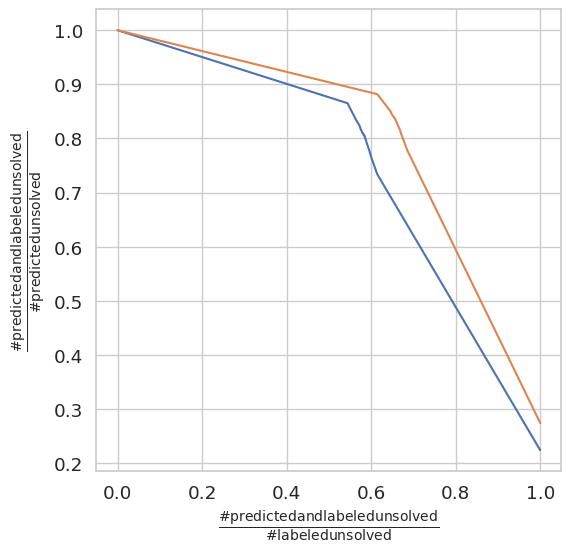

In [19]:
f, ax = plt.subplots(figsize=(6, 6))

ax.plot(data[:, 1], data[:, 2])
ax.plot(data2[:, 1], data2[:, 2])

ax.set_xlabel(r'$\frac{\# \mathrm{predicted and labeled unsolved}}{\# \mathrm{labeled unsolved}}$') 
ax.set_ylabel(r'$\frac{\# \mathrm{predicted and labeled unsolved}}{\# \mathrm{predicted unsolved}}$')

plt.show()

### Here!!

In [20]:
data = []
data2 = []

df_label_cp['MB'] = df_label_cp['MB'].astype(int)
df_pred_cp['MB'] = df_pred_cp['MB'].astype(int)

for thr in np.array([0.01*i for i in range(101)]):
    # compound wised 
    df_pred_c['Prob2Cls'] = df_pred_c['Pred_b'].apply(lambda x: prob2cls(x, thr))
    df_c = df_label_c.merge(df_pred_c, on=['SMILES'], how='inner')
    
    x = len(df_c[(df_c['Prob2Cls'] == 0) & (df_c['Y_b'] == 0)]) / len(df_c[df_c['Y_b'] == 0])
    y = len(df_c[(df_c['Prob2Cls'] == 1) & (df_c['Y_b'] == 1)]) / len(df_c[df_c['Y_b'] == 1])
    
    data.append((thr, x, y))
        
    # compound & phase wised
    df_pred_cp['Prob2Cls'] = df_pred_cp['Pred_b'].apply(lambda x: prob2cls(x, thr))
    df_cp = df_label_cp.merge(df_pred_cp, on=['SMILES', 'MB'], how='inner')
    
    x2 = len(df_cp[(df_cp['Prob2Cls'] == 0) & (df_cp['Y_b'] == 0)]) / len(df_cp[df_cp['Y_b'] == 0])
    y2 = len(df_cp[(df_cp['Prob2Cls'] == 1) & (df_cp['Y_b'] == 1)]) / len(df_cp[df_cp['Y_b'] == 1])
    
    data2.append((thr, x2, y2))
    
data = np.array(data)
data2 = np.array(data2)

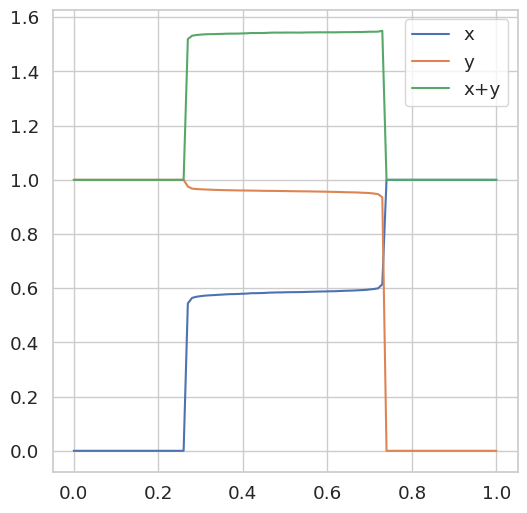

In [21]:
f, ax = plt.subplots(figsize=(6, 6))

ax.plot(data[:, 0], data[:, 1], label='x')
ax.plot(data[:, 0], data[:, 2], label='y')
ax.plot(data[:, 0], data[:, 1]+data[:, 2], label='x+y')

plt.legend()
plt.show()

In [22]:
max_xy = 0
max_thr = 0
max_x = 0
max_y = 0

for thr, x, y in data:
    if x + y > max_xy:
        max_xy = x + y
        max_thr = thr
        max_x = x
        max_y = y
        
print('When threshold is {}, we got solved accuracy of {} and unsolved accuracy of {}.'.format(max_thr, max_x, max_y))

When threshold is 0.73, we got solved accuracy of 0.6143435365545156 and unsolved accuracy of 0.9356879090344046.


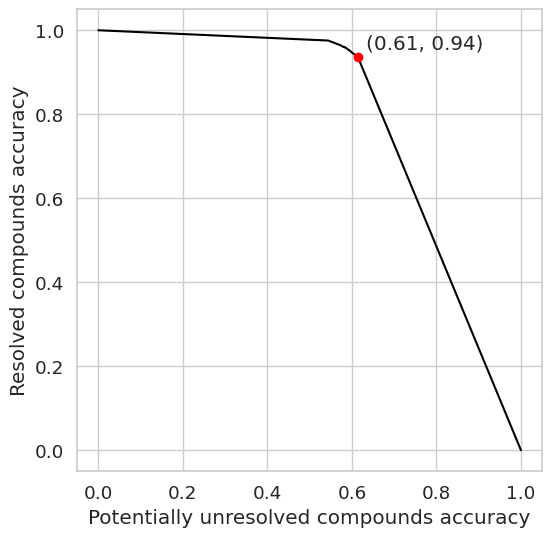

In [26]:
f, ax = plt.subplots(figsize=(6, 6))

ax.plot(data[:, 1], data[:, 2], label='compound wised', color='black')
plt.plot(max_x, max_y, marker="o", markersize=6, markeredgecolor="red", markerfacecolor="red")
plt.text(max_x+0.02, max_y+0.02, '({:.2f}, {:.2f})'.format(max_x, max_y))

# ax.set_xlabel(r'$\frac{\# \mathrm{predicted and labeled unsolved}}{\# \mathrm{labeled unsolved}}$') 
# ax.set_ylabel(r'$\frac{\# \mathrm{predicted and labeled solved}}{\# \mathrm{labeled solved}}$')
ax.set_xlabel('Potentially unresolved compounds accuracy')
ax.set_ylabel('Resolved compounds accuracy')

plt.savefig('./unresolved_compounds.eps', dpi=600, bbox_inches='tight', format='eps')
plt.savefig('./unresolved_compounds.png', dpi=600, bbox_inches='tight')
plt.show()
plt.show()

In [24]:
f, ax = plt.subplots(figsize=(6, 6))

precision, recall, thresholds = metrics.precision_recall_curve(df_cp['Y_b'], df_cp['Pred_b'])
ax.plot(recall, precision)

precision, recall, thresholds = metrics.precision_recall_curve(df_c['Y_b'], df_c['Pred_b'])
ax.plot(recall, precision)

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve"); 

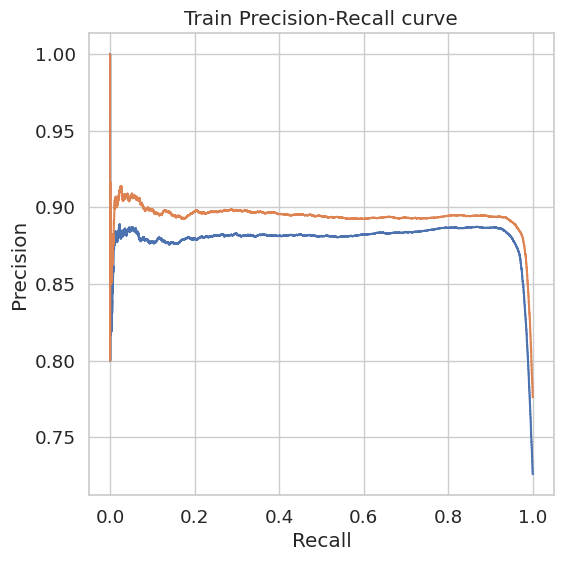

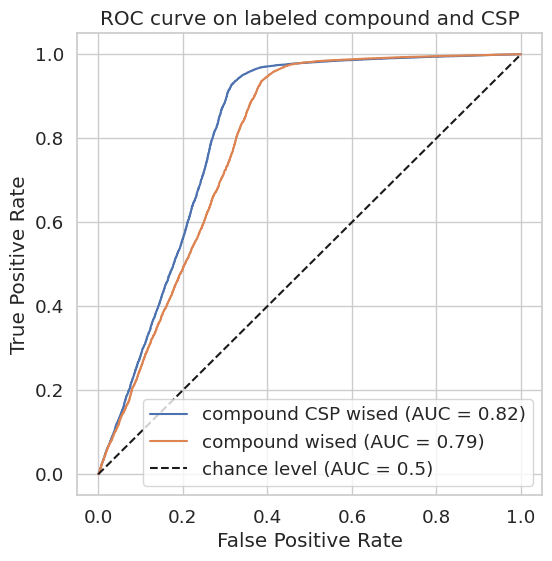

In [25]:
f, ax = plt.subplots(figsize=(6, 6))

fpr, tpr, thresh = metrics.roc_curve(df_cp['Y_b'], df_cp['Pred_b'])
auc = metrics.roc_auc_score(df_cp['Y_b'], df_cp['Pred_b'])
ax.plot(fpr, tpr, label="compound CSP wised (AUC = {:.2f})".format(auc))

fpr, tpr, thresh = metrics.roc_curve(df_c['Y_b'], df_c['Pred_b'])
auc = metrics.roc_auc_score(df_c['Y_b'], df_c['Pred_b'])
ax.plot(fpr, tpr, label="compound wised (AUC = {:.2f})".format(auc))

ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curve on labeled compound and CSP")
ax.legend()
plt.show()